# Prédiction des frais médicaux

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge

## Exploration et Préparation des Données

Each row in the dataset represents an individual's attributes such as:
* age: Age of the individual.
* sex: Gender of the individual (male or female).
* bmi: Body Mass Index, a measure of body fat based on height and weight.
* children: Number of children/dependents covered by the insurance.
* smoker: Whether the individual is a smoker (yes or no).
* region: The region where the individual resides (northwest, southeast, southwest, northeast).
* expenses: Annual medical expenses billed by health insurance.

The problems to solve
* Charger et visualiser les données pour comprendre leur structure.
* Nettoyer les données en traitant les valeurs manquantes et en gérant les outliers.
* Analyser les variables et sélectionner celles qui ont le plus d'impact sur les frais médicaux.

## Data Set

In [3]:
# Get the current working directory
current_directory = os.getcwd()

# Correctly join the path to the data file, relative to the script's location
file_path = os.path.join(current_directory, "../data", "insurance.csv")

# Read the CSV file into a DataFrame
insurdata = pd.read_csv(file_path)#, dtype=dtypes
d,h=insurdata.shape
print('Initial data set has',d,' lines')

Initial data set has 1338  lines


### We can check initial info about data

In [26]:
print(insurdata.dtypes)
print(insurdata.columns)
insurdata.head()

age         float64
sex           int32
bmi         float64
children    float64
smoker        int32
region        int32
expenses    float64
havyCase      int64
dtype: object
Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'expenses',
       'havyCase'],
      dtype='object')


,age,sex,bmi,children,smoker,region,expenses,havyCase
0,-1.438764,0,-0.453646,-0.908614,1,3,16884.92,0
1,-1.509965,1,0.514186,-0.078767,0,2,1725.55,0
2,-0.797954,1,0.382954,1.580926,0,2,4449.46,0
3,-0.441948,1,-1.306650,-0.908614,0,1,21984.47,0
4,-0.513149,1,-0.289606,-0.908614,0,1,3866.86,0


In [27]:
insurdata.describe(include='all')

,age,sex,bmi,children,smoker,region,expenses,havyCase
count,1.338000e+03,1338.000000,1.338000e+03,1.338000e+03,1338.000000,1338.000000,1338.000000,1338.000000
mean,-1.805565e-16,0.505232,-4.089073e-16,-5.576008e-17,0.204783,1.515695,13270.422414,0.138266
std,1.000374e+00,0.500160,1.000374e+00,1.000374e+00,0.403694,1.104885,12110.011240,0.345308
min,-1.509965e+00,0.000000,-2.405713e+00,-9.086137e-01,0.000000,0.000000,1121.870000,0.000000
25%,-8.691547e-01,0.000000,-7.161085e-01,-9.086137e-01,0.000000,1.000000,4740.287500,0.000000
50%,-1.474046e-02,1.000000,-4.354763e-02,-7.876719e-02,0.000000,2.000000,9382.030000,0.000000
75%,8.396738e-01,1.000000,6.618210e-01,7.510793e-01,0.000000,2.000000,16639.915000,0.000000
max,1.765289e+00,1.000000,3.680143e+00,3.240619e+00,1.000000,3.000000,63770.430000,1.000000


In [43]:
# Calculate the 1st and 99th percentiles and clean the data 
lower_bound = insurdata['expenses'].quantile(0.01) 
upper_bound = insurdata['expenses'].quantile(0.99) 
insurdata = insurdata[(insurdata['expenses'] >= lower_bound) & (insurdata['expenses'] <= upper_bound)]

## Missing values if any

In [28]:
# 1. Handling Missing Values 
# Check for missing values 
print(insurdata.isnull().sum()) 
# If there are any missing values, you can handle them, e.g., by filling with mean/mode or dropping 
# df = df.dropna() 
# Alternatively, you can fill missing values using df.fillna()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
expenses    0
havyCase    0
dtype: int64


This dataset does not contain missing values

## Working with Categorical Variables

In [7]:
# Encoding Categorical Variables
# Initialize label encoders 
le_sex = LabelEncoder() 
le_smoker = LabelEncoder() 
le_region = LabelEncoder() 

# Apply label encoding 
insurdata['sex'] = le_sex.fit_transform(insurdata['sex']) 
insurdata['smoker'] = le_smoker.fit_transform(insurdata['smoker']) 
insurdata['region'] = le_region.fit_transform(insurdata['region'])


## Feature scaling and some additional transformations

In [29]:
# Feature Scaling
# Initialize the scaler scaler

scaler = StandardScaler()

# Apply scaling to numerical features 
insurdata[['age', 'bmi', 'children']] = scaler.fit_transform(insurdata[['age', 'bmi', 'children']])

# Create a binary 'expenses' column to indicate "havy medical cases"
insurdata['havyCase'] = insurdata['expenses'].apply(lambda x: 1 if x > 27000 else 0)

In [30]:
insurdata.tail()

,age,sex,bmi,children,smoker,region,expenses,havyCase
1333,0.768473,1,0.054876,1.580926,0,1,10600.55,0
1334,-1.509965,0,0.202511,-0.908614,0,0,2205.98,0
1335,-1.509965,0,1.022707,-0.908614,0,2,1629.83,0
1336,-1.296362,0,-0.798128,-0.908614,0,3,2007.95,0
1337,1.551686,0,-0.256799,-0.908614,1,1,29141.36,1


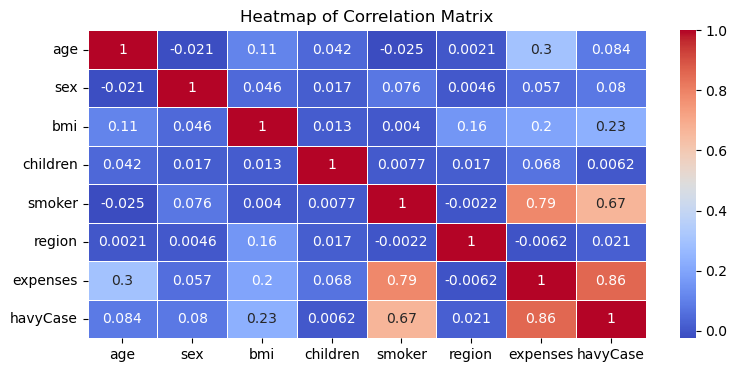

In [31]:
# Calculer la matrice de corrélation 
corr_matrix = insurdata.corr() 
# Créer la heatmap 
plt.figure(figsize=(9, 4)) 
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=.5) 
plt.title('Heatmap of Correlation Matrix') 
plt.show()

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

import statsmodels.api as sm

### Statistical analysis of the data for model selection

**Linear Regression**

In [44]:
lr=LinearRegression()
X=insurdata[['age', 'bmi', 'children','sex','smoker','region','havyCase']]
Y=insurdata[['expenses']]
lr.fit(X,Y)
Y_hat=lr.predict(X)
intercept=lr.intercept_
coeff=lr.coef_
r_squared = r2_score(Y, Y_hat)
print(f"Intercept: {intercept}") 
print(f"Coefficients: {coeff}") 
print(f"R²: {r_squared}")


Intercept: [8603.72911486]
Coefficients: [[ 3061.61751558   514.24046992   638.2356548   -341.22823492
  12900.96836179  -270.98230585 18104.58604124]]
R²: 0.8909241115987613


**Polynomial Regression**

In [45]:
# Create polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Get the names of the polynomial features
feature_names = poly.get_feature_names_out(input_features=X.columns)
print("Polynomial feature names:\n", feature_names)

# Fit the model
lr_poly = LinearRegression()
lr_poly.fit(X_poly, Y)

# Make predictions
Y_hat_poly = lr_poly.predict(X_poly)

# Calculate R²
r_squared_poly = r2_score(Y, Y_hat_poly)
print(f"R²: {r_squared_poly}")

# Use statsmodels for detailed summary and p-values
X_poly = sm.add_constant(X_poly)  # Add intercept term
model = sm.OLS(Y, X_poly).fit()
summary = model.summary()

# Print model summary to see p-values
print(summary)

# Selecting significant coefficients (p-value < 0.05)
significant_features = model.pvalues[model.pvalues < 0.05].index
print(f"Significant features: {significant_features}")

# Mapping statsmodels feature names to actual feature names
final_features = ['const'] + list(feature_names)

# Displaying final model with significant coefficients
print("Final Model with Significant Coefficients:")
for i in significant_features:
    feature_name = 'Intercept' if i == 'const' else final_features[int(i[1:])]
    print(f"{feature_name}: {model.params[i]}")


Polynomial feature names:
 ['age' 'bmi' 'children' 'sex' 'smoker' 'region' 'havyCase' 'age^2'
 'age bmi' 'age children' 'age sex' 'age smoker' 'age region'
 'age havyCase' 'bmi^2' 'bmi children' 'bmi sex' 'bmi smoker' 'bmi region'
 'bmi havyCase' 'children^2' 'children sex' 'children smoker'
 'children region' 'children havyCase' 'sex^2' 'sex smoker' 'sex region'
 'sex havyCase' 'smoker^2' 'smoker region' 'smoker havyCase' 'region^2'
 'region havyCase' 'havyCase^2']
R²: 0.9073107360487163
                            OLS Regression Results                            
Dep. Variable:               expenses   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     390.6
Date:                Mon, 25 Nov 2024   Prob (F-statistic):               0.00
Time:                        16:12:30   Log-Likelihood:                -12541.
No. Observations:               

**Kernel of two destributions**

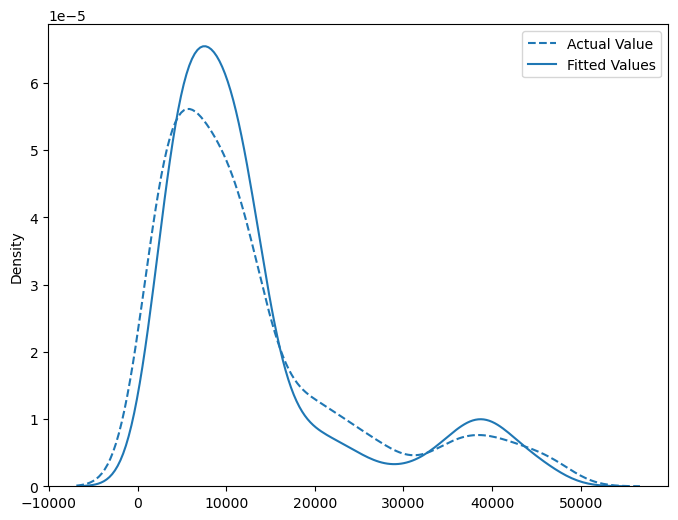

In [46]:
plt.figure(figsize=(8, 6))

# Plotting the Actual Values
ax1 = sns.kdeplot(Y, color="red", linestyle='--', label="Actual Value")
# Plotting the Fitted Values
sns.kdeplot(Y_hat_poly, color="blue", label="Fitted Values", ax=ax1)
# Adding the legend to the plot
ax1.legend()
# Display the plot
plt.show()
# Close the plot
plt.close()

### Conclusions

These statistical results show that the structural and parametric identification can be done with good presicion in case of this data set. 

## ML model selection

### Séparation des Données :

Diviser les données en ensembles d'entraînement et de test.

Normaliser ou standardiser les données si nécessaire.

In [48]:
# Split the dataset into training and testing sets 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42) 
# Check the size of the training and testing sets 
print(f"Training set size: {X_train.shape[0]} samples") 
print(f"Testing set size: {X_test.shape[0]} samples")

Training set size: 1048 samples
Testing set size: 262 samples


## ML Polinomial Model

In [49]:
# Create the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),                     # Step 1: Scale the features
    ('poly', PolynomialFeatures(degree=2, include_bias=False)), # Step 2: Generate polynomial features
    ('linear', LinearRegression())                    # Step 3: Fit linear regression model
])

# Fit the pipeline on training data
pipeline.fit(X_train, Y_train)

# Make predictions on training and testing sets
Y_train_pred = pipeline.predict(X_train)
Y_test_pred = pipeline.predict(X_test)

# Calculate R² for training and testing sets
r2_train = r2_score(Y_train, Y_train_pred)
r2_test = r2_score(Y_test, Y_test_pred)

print(f"R² on Training Set: {r2_train}")
print(f"R² on Testing Set: {r2_test}")

# Get the polynomial features names
poly = pipeline.named_steps['poly']
feature_names = poly.get_feature_names_out(input_features=X.columns)
print("Polynomial feature names:\n", feature_names)

# Use statsmodels for detailed summary and p-values on training data
X_train_poly = poly.transform(X_train)
X_train_poly = sm.add_constant(X_train_poly)  # Add intercept term
model = sm.OLS(Y_train, X_train_poly).fit()
summary = model.summary()

# Print model summary to see p-values
print(summary)

# Selecting significant coefficients (p-value < 0.05)
significant_features = model.pvalues[model.pvalues < 0.05].index
print(f"Significant features: {significant_features}")

# Mapping statsmodels feature names to actual feature names
final_features = ['const'] + list(feature_names)

# Displaying final model with significant coefficients
print("Final Model with Significant Coefficients:")
for i in significant_features:
    feature_name = 'Intercept' if i == 'const' else final_features[int(i[1:])]
    print(f"{feature_name}: {model.params[i]}")


R² on Training Set: 0.9027862663723679
R² on Testing Set: 0.9238261185263024
Polynomial feature names:
 ['age' 'bmi' 'children' 'sex' 'smoker' 'region' 'havyCase' 'age^2'
 'age bmi' 'age children' 'age sex' 'age smoker' 'age region'
 'age havyCase' 'bmi^2' 'bmi children' 'bmi sex' 'bmi smoker' 'bmi region'
 'bmi havyCase' 'children^2' 'children sex' 'children smoker'
 'children region' 'children havyCase' 'sex^2' 'sex smoker' 'sex region'
 'sex havyCase' 'smoker^2' 'smoker region' 'smoker havyCase' 'region^2'
 'region havyCase' 'havyCase^2']
                            OLS Regression Results                            
Dep. Variable:               expenses   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     294.6
Date:                Mon, 25 Nov 2024   Prob (F-statistic):               0.00
Time:                        16:15:02   Log-Likelihood:  

C:\Users\darya\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  warnings.warn(


## ML Linear Model

In [50]:
# Create the pipeline for linear regression
pipeline_linear = Pipeline([
    ('scaler', StandardScaler()),  # Step 1: Scale the features
    ('linear', LinearRegression())  # Step 2: Fit linear regression model
])

# Fit the pipeline on training data
pipeline_linear.fit(X_train, Y_train)

# Make predictions on training and testing sets
Y_train_pred = pipeline_linear.predict(X_train)
Y_test_pred = pipeline_linear.predict(X_test)

# Calculate R² for training and testing sets
r2_train = r2_score(Y_train, Y_train_pred)
r2_test = r2_score(Y_test, Y_test_pred)

print(f"R² on Training Set: {r2_train}")
print(f"R² on Testing Set: {r2_test}")

# Use statsmodels for detailed summary and p-values on training data
X_train_scaled = pipeline_linear.named_steps['scaler'].transform(X_train)
X_train_scaled = sm.add_constant(X_train_scaled)  # Add intercept term
model = sm.OLS(Y_train, X_train_scaled).fit()
summary = model.summary()

# Print model summary to see p-values
print(summary)

# Selecting significant coefficients (p-value < 0.05)
significant_features = model.pvalues[model.pvalues < 0.05].index
print(f"Significant features: {significant_features}")

# Displaying final model with significant coefficients
print("Final Model with Significant Coefficients:")
for i in significant_features:
    feature_name = 'Intercept' if i == 'const' else X.columns[int(i[1:]) - 1]
    print(f"{feature_name}: {model.params[i]}")


R² on Training Set: 0.8870528884099623
R² on Testing Set: 0.9059740562005927
                            OLS Regression Results                            
Dep. Variable:               expenses   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     1167.
Date:                Mon, 25 Nov 2024   Prob (F-statistic):               0.00
Time:                        16:15:13   Log-Likelihood:                -10136.
No. Observations:                1048   AIC:                         2.029e+04
Df Residuals:                    1040   BIC:                         2.033e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

## Optimisation du Modèle :

Affiner le modèle en ajustant les hyperparamètres.

Utiliser des techniques de validation croisée pour améliorer la robustesse du modèle.

In [37]:
from sklearn.model_selection import train_test_split, GridSearchCV

In [51]:

# Split the dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Create the pipeline for Ridge regression
pipeline_ridge = Pipeline([
    ('scaler', StandardScaler()),  # Step 1: Scale the features
    ('ridge', Ridge())             # Step 2: Fit Ridge regression model
])

# Define the hyperparameter grid
param_grid = {
    'ridge__alpha': [0.1, 1.0, 10.0, 100.0]  # Different values for alpha to try
}

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(pipeline_ridge, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, Y_train)

# Get the best estimator
best_model = grid_search.best_estimator_

# Make predictions on training and testing sets
Y_train_pred = best_model.predict(X_train)
Y_test_pred = best_model.predict(X_test)

# Calculate R² for training and testing sets
r2_train = r2_score(Y_train, Y_train_pred)
r2_test = r2_score(Y_test, Y_test_pred)

print(f"R² on Training Set: {r2_train}")
print(f"R² on Testing Set: {r2_test}")

print(f"Best Hyperparameters: {grid_search.best_params_}")

# Use statsmodels for detailed summary and p-values on training data
X_train_scaled = best_model.named_steps['scaler'].transform(X_train)
X_train_scaled = sm.add_constant(X_train_scaled)  # Add intercept term
model = sm.OLS(Y_train, X_train_scaled).fit()
summary = model.summary()

# Print model summary to see p-values
print(summary)

# Selecting significant coefficients (p-value < 0.05)
significant_features = model.pvalues[model.pvalues < 0.05].index
print(f"Significant features: {significant_features}")

# Displaying final model with significant coefficients
print("Final Model with Significant Coefficients:")
for i in significant_features:
    feature_name = 'Intercept' if i == 'const' else X.columns[int(i[1:]) - 1]
    print(f"{feature_name}: {model.params[i]}")

R² on Training Set: 0.8870525486823575
R² on Testing Set: 0.9059643316656191
Best Hyperparameters: {'ridge__alpha': 1.0}
                            OLS Regression Results                            
Dep. Variable:               expenses   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     1167.
Date:                Mon, 25 Nov 2024   Prob (F-statistic):               0.00
Time:                        16:15:21   Log-Likelihood:                -10136.
No. Observations:                1048   AIC:                         2.029e+04
Df Residuals:                    1040   BIC:                         2.033e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------

## Prediction power

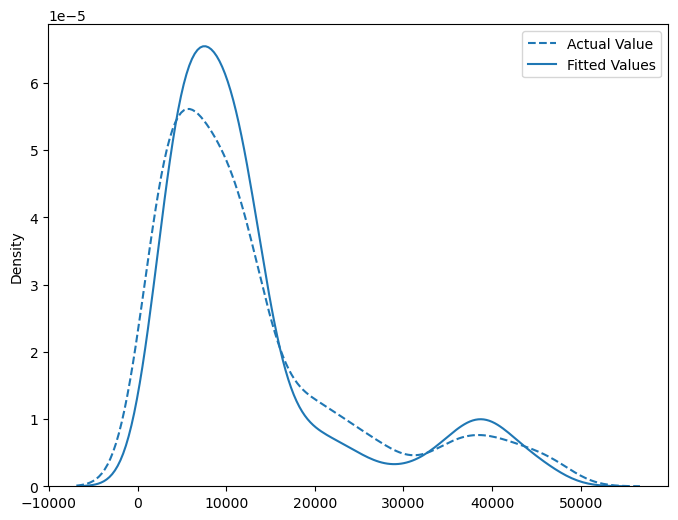

In [52]:
plt.figure(figsize=(8, 6))

# Plotting the Actual Values
ax1 = sns.kdeplot(Y, color="red", linestyle='--', label="Actual Value")
# Plotting the Fitted Values
sns.kdeplot(Y_hat_poly, color="blue", label="Fitted Values", ax=ax1)
# Adding the legend to the plot
ax1.legend()
# Display the plot
plt.show()
# Close the plot
plt.close()

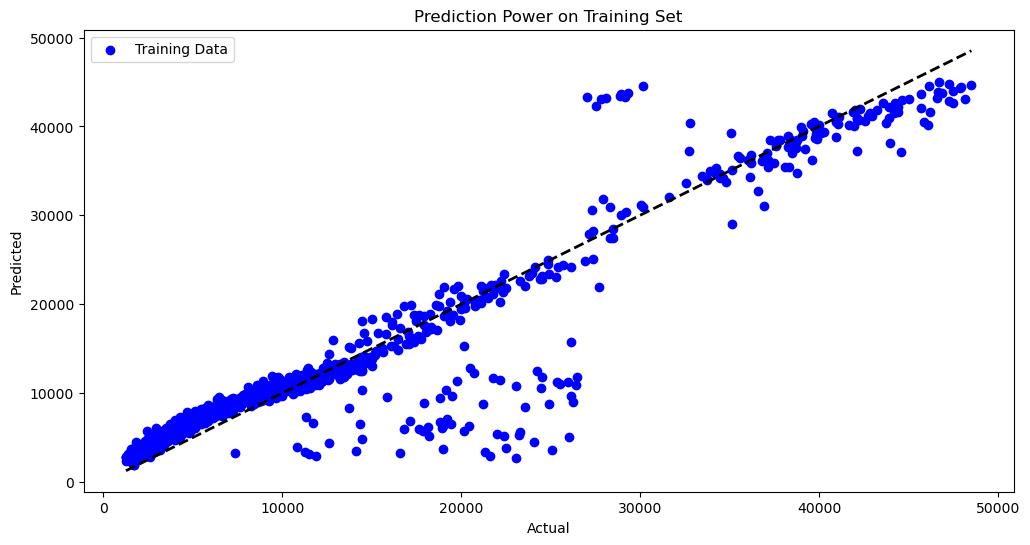

In [53]:
# Plot Prediction Power for Training Set 
plt.figure(figsize=(12, 6)) 
plt.scatter(Y_train, Y_train_pred, label='Training Data', color='blue') 
plt.plot([Y_train.min(), Y_train.max()], [Y_train.min(), Y_train.max()], 'k--', linewidth=2) 
plt.xlabel('Actual') 
plt.ylabel('Predicted') 
plt.title('Prediction Power on Training Set') 
plt.legend() 
plt.show() 

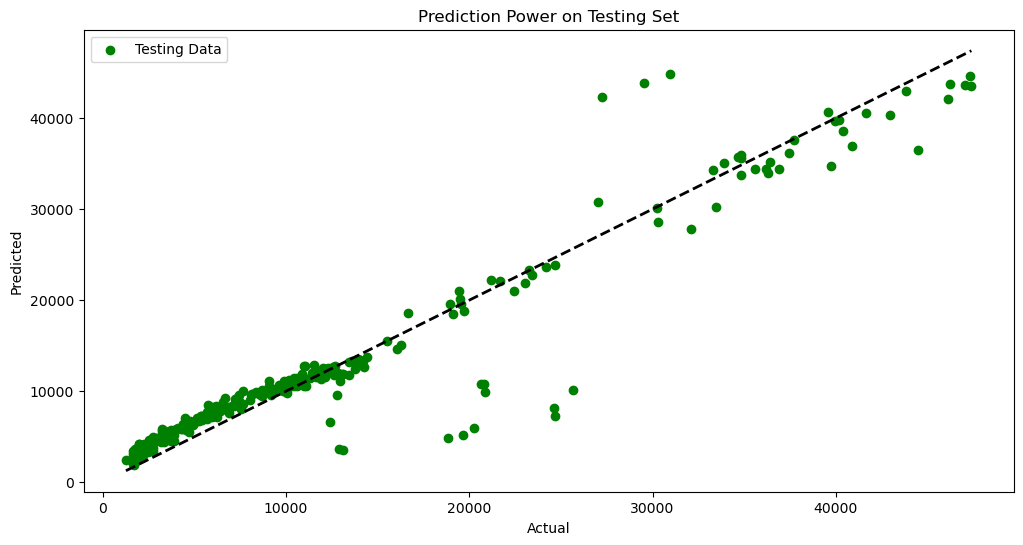

In [54]:
# Plot Prediction Power for Testing Set 
plt.figure(figsize=(12, 6)) 
plt.scatter(Y_test, Y_test_pred, label='Testing Data', color='green') 
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'k--', linewidth=2) 
plt.xlabel('Actual') 
plt.ylabel('Predicted') 
plt.title('Prediction Power on Testing Set') 
plt.legend() 
plt.show()

## Rapport and Recommandations

**Model Coefficients:**
* Intercept (13041.15): The baseline value of expenses when all predictors are zero.
* Age (3031.13): For each one-unit increase in age, the expenses increase by approximately 3031.13 units.
* BMI (462.89): For each one-unit increase in BMI, the expenses increase by approximately 462.89 units.
* Children (666.87): For each one-unit increase in the number of children, the expenses increase by approximately 666.87 units.
* Smoker (5165.31): Being a smoker increases the expenses by approximately 5165.31 units.
* Region (-277.94): This variable shows a negative impact on expenses and will vary depending on the encoded values.
* Heavy Case (6057.49): This significant coefficient suggests a substantial increase in expenses for heavy cases.


**Recommendations:** 

* Model Evaluation: The high R² values for both training and testing sets indicate that the model performs well in explaining the variance of the target variable. However, always be cautious about potential overfitting.
* Feature Importance: The significant coefficients like age, bmi, children, and smoker suggest these features are influential predictors of expenses. Focus on these variables for targeted interventions or further detailed analysis.
* Regularization: Ridge regression with alpha=1.0 worked well for this model. Regularization helps to prevent overfitting and ensures better generalization to new data.
* Data Quality: Ensure the data quality and feature selection process are robust. Considering transformations or additional feature engineering could further improve model performance.

**Potential Actions:**

* Health Programs: Target health programs at smokers to potentially reduce insurance expenses.
* Age-Specific Policies: Develop insurance policies that take age and number of children into account, as these significantly impact expenses.
* BMI Interventions: Consider wellness programs that aim to manage BMI, which also affects expenses significantly.

**Next Steps:**

* Cross-Validation: Continue validating the model using different subsets of the data to ensure consistent performance.
* Model Improvement: Explore other models or ensemble methods to see if there are potential improvements in performance.
* Monitoring: Regularly monitor the model’s performance and update it with new data to maintain its accuracy and reliability.

In [56]:
from sklearn.model_selection import cross_val_score

Cross-Validation Scores: [0.8433392  0.89415062 0.86055945 0.90912233 0.91935501]
Mean Cross-Validation Score: 0.8853053231933522
R² on Training Set: 0.8870525486823575
R² on Testing Set: 0.9059643316656191
Best Hyperparameters: {'ridge__alpha': 1.0}


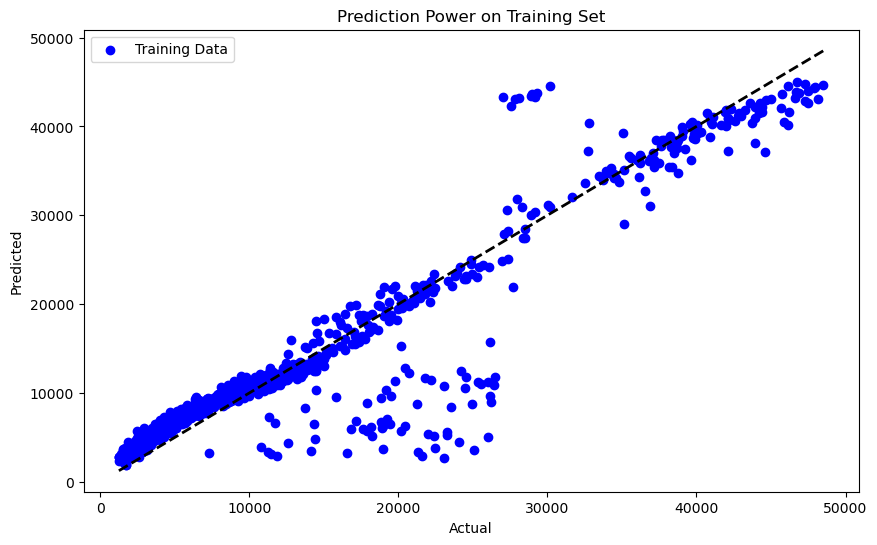

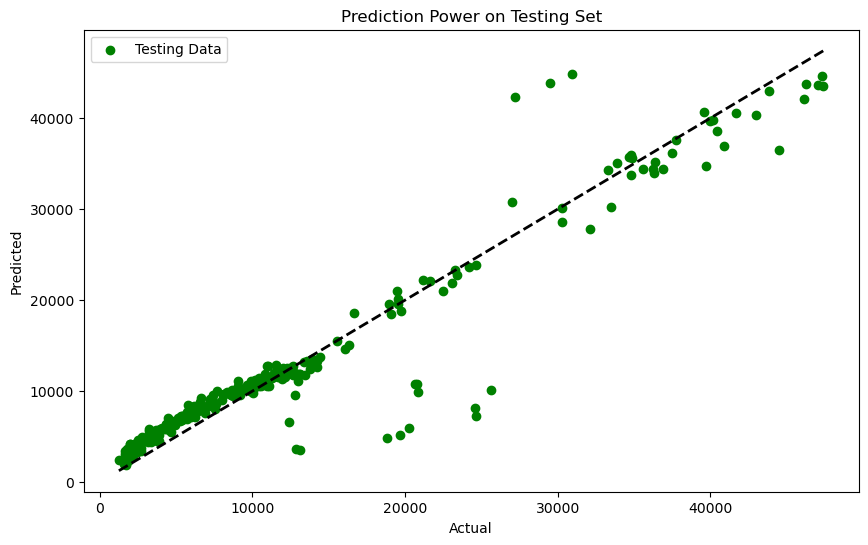

                            OLS Regression Results                            
Dep. Variable:               expenses   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     1167.
Date:                Mon, 25 Nov 2024   Prob (F-statistic):               0.00
Time:                        16:31:22   Log-Likelihood:                -10136.
No. Observations:                1048   AIC:                         2.029e+04
Df Residuals:                    1040   BIC:                         2.033e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.304e+04    118.989    109.600      0.0

In [58]:
# Split the dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Create the pipeline for Ridge regression
pipeline_ridge = Pipeline([
    ('scaler', StandardScaler()),  # Step 1: Scale the features
    ('ridge', Ridge())             # Step 2: Fit Ridge regression model
])

# Define the hyperparameter grid
param_grid = {
    'ridge__alpha': [0.1, 1.0, 10.0, 100.0]  # Different values for alpha to try
}

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(pipeline_ridge, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, Y_train)

# Get the best estimator
best_model = grid_search.best_estimator_

# Cross-validate the model
cv_scores = cross_val_score(best_model, X_train, Y_train, cv=5, scoring='r2')

print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Score: {cv_scores.mean()}")

# Make predictions on training and testing sets
Y_train_pred = best_model.predict(X_train)
Y_test_pred = best_model.predict(X_test)

# Calculate R² for training and testing sets
r2_train = r2_score(Y_train, Y_train_pred)
r2_test = r2_score(Y_test, Y_test_pred)

print(f"R² on Training Set: {r2_train}")
print(f"R² on Testing Set: {r2_test}")

print(f"Best Hyperparameters: {grid_search.best_params_}")

# Plot Prediction Power for Training Set
plt.figure(figsize=(10, 6))
plt.scatter(Y_train, Y_train_pred, label='Training Data', color='blue')
plt.plot([Y_train.min(), Y_train.max()], [Y_train.min(), Y_train.max()], 'k--', linewidth=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Prediction Power on Training Set')
plt.legend()
plt.show()

# Plot Prediction Power for Testing Set
plt.figure(figsize=(10, 6))
plt.scatter(Y_test, Y_test_pred, label='Testing Data', color='green')
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'k--', linewidth=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Prediction Power on Testing Set')
plt.legend()
plt.show()

# Use statsmodels for detailed summary and p-values on training data
X_train_scaled = best_model.named_steps['scaler'].transform(X_train)
X_train_scaled = sm.add_constant(X_train_scaled)  # Add intercept term
model = sm.OLS(Y_train, X_train_scaled).fit()
summary = model.summary()

# Print model summary to see p-values
print(summary)

# Selecting significant coefficients (p-value < 0.05)
significant_features = model.pvalues[model.pvalues < 0.05].index
print(f"Significant features: {significant_features}")

# Displaying final model with significant coefficients
print("Final Model with Significant Coefficients:")
for i in significant_features:
    feature_name = 'Intercept' if i == 'const' else X.columns[int(i[1:]) - 1]
    print(f"{feature_name}: {model.params[i]}")

## Prediction Model to export

In [1]:
def get_user_input():
    data = {
        "age": None,
        "bmi": None,
        "children": None,
        "smoker": None,
        "region": None,
        "heavyCase": None
    }
    
    try:
        data["age"] = float(input("Enter age: "))
        data["bmi"] = float(input("Enter BMI: "))
        data["children"] = int(input("Enter number of children: "))
        data["smoker"] = int(input("Are you a smoker? (1 for Yes, 0 for No): "))
        data["region"] = int(input("Enter region (as an integer 1,2,3 or 4): "))
        data["heavyCase"] = int(input("Is this a heavy case? (1 for Yes, 0 for No): "))
    except ValueError as e:
        print(f"Invalid input: {e}")
    
    return data

def predict_expenses(data, coefficients):
    prediction = coefficients["Intercept"]
    for key in data:
        prediction += coefficients[key] * data[key]
    return prediction

if __name__ == "__main__":
    user_data = get_user_input()
    print("Entered data:", user_data)

    significant_coefficients = {
        "Intercept": 13041.15169847328,
        "age": 3031.133367457519,
        "bmi": 462.8933240358457,
        "children": 666.8734098322169,
        "smoker": 5165.31080344811,
        "region": -277.93606962268314,
        "heavyCase": 6057.491938649431
    }
    
    predicted_expense = predict_expenses(user_data, significant_coefficients)
    print(f"Predicted medical expenses: {predicted_expense:.2f}")


Enter age: 23
Enter BMI: 23
Enter number of children: 3
Are you a smoker? (1 for Yes, 0 for No): 0
Enter region (as an integer 1,2,3 or 4): 4
Is this a heavy case? (1 for Yes, 0 for No): 1
Entered data: {'age': 23.0, 'bmi': 23.0, 'children': 3, 'smoker': 0, 'region': 4, 'heavyCase': 1}
Predicted medical expenses: 100350.13


In [4]:
import pickle

def get_user_input():
    data = {
        "age": None,
        "bmi": None,
        "children": None,
        "smoker": None,
        "region": None,
        "heavyCase": None
    }
    
    try:
        data["age"] = float(input("Enter age: "))
        data["bmi"] = float(input("Enter BMI: "))
        data["children"] = int(input("Enter number of children: "))
        data["smoker"] = int(input("Are you a smoker? (1 for Yes, 0 for No): "))
        data["region"] = int(input("Enter region (as an integer 1,2,3 or 4): "))
        data["heavyCase"] = int(input("Is this a heavy case? (1 for Yes, 0 for No): "))
    except ValueError as e:
        print(f"Invalid input: {e}")
    
    return data

def predict_expenses(data, coefficients):
    prediction = coefficients["Intercept"]
    for key in data:
        prediction += coefficients[key] * data[key]
    return prediction

if __name__ == "__main__":
    user_data = get_user_input()
    print("Entered data:", user_data)

    significant_coefficients = {
        "Intercept": 13041.15169847328,
        "age": 3031.133367457519,
        "bmi": 462.8933240358457,
        "children": 666.8734098322169,
        "smoker": 5165.31080344811,
        "region": -277.93606962268314,
        "heavyCase": 6057.491938649431
    }
    
    # Predict expenses
    predicted_expense = predict_expenses(user_data, significant_coefficients)
    print(f"Predicted medical expenses: {predicted_expense:.2f}")
    
    # Pickle the model
    with open('simpleRegression.pkl', 'wb') as file:
        pickle.dump(significant_coefficients, file)
    print("Model coefficients have been pickled to 'simpleRegression.pkl'")

    # Load the pickled model (for demonstration purposes)
    with open('model_coefficients.pkl', 'rb') as file:
        loaded_coefficients = pickle.load(file)
    print("Loaded coefficients:", loaded_coefficients)
    
    # Predict using the loaded model
    loaded_predicted_expense = predict_expenses(user_data, loaded_coefficients)
    print(f"Predicted medical expenses using loaded model: {loaded_predicted_expense:.2f}")


Enter age: 23
Enter BMI: 25
Enter number of children: 2
Are you a smoker? (1 for Yes, 0 for No): 1
Enter region (as an integer 1,2,3 or 4): 2
Is this a heavy case? (1 for Yes, 0 for No): 1
Entered data: {'age': 23.0, 'bmi': 25.0, 'children': 2, 'smoker': 1, 'region': 2, 'heavyCase': 1}
Predicted medical expenses: 106330.23
Model coefficients have been pickled to 'simpleRegression.pkl'
Loaded coefficients: {'Intercept': 13041.15169847328, 'age': 3031.133367457519, 'bmi': 462.8933240358457, 'children': 666.8734098322169, 'smoker': 5165.31080344811, 'region': -277.93606962268314, 'heavyCase': 6057.491938649431}
Predicted medical expenses using loaded model: 106330.23
